# LA_1651

Nachdem Sie in der `LA_1650` gesehen haben, wie eine ML-*pipeline* im einfachsten Fall aussehen kann, gehen wir nun in diesem größeren Auftrag einen Schritt weiter, und versuchen, einen weniger vorgetretenen Pfad zu begehen: Statt des vorbereiteten Iris-Datensatzes versuchen wir nun, ein Modell für unseren Titanic-Datensatz zu erstellen, und können somit auf einige Feinheiten eingehen!

⚠️ In diesem Auftrag müssen Sie viel [recherchieren](https://scikit-learn.org/stable/user_guide.html) und in den vorhergegangenen Aufträgen nachlesen, welche Funktionen wie heissen und welche Parameter diese haben - lassen Sie sich nicht frustrieren, *that's part of the job!* und mit etwas Übung wird es Ihnen in Zukunft leichter fallen, schnell an die wichtigen Informationen zu kommen. Ansonsten läuft dieser Auftrag aber wie in den bisherigen Notizbüchern ab - füllen Sie die Teile ein, die mit `# 👾 TODO` markiert sind.

## Teil 1: Laden der Daten

Im `LA_1650` konnten wir den Iris-Datensatz direkt durch `sklearn` importieren; dieser [Spielzeug-Datensatz](https://scikit-learn.org/stable/datasets/toy_dataset.html) wird mitgeliefert. Aber natürlich können Sie nicht Ihre ML-Karriere nur auf mitgelieferten Datensätzen aufbauen, darum geht es in diesem ersten Schritt darum, wie Sie andere Datensätze für `sklearn` zugänglich machen. Glücklicherweise ist `sklearn` weitgehend mit `pandas` kompatibel, und so können Sie den Titanic-Datensatz laden, wie Sie es sich gewohnt sind!

In [238]:
# 👾 TODO: Load the titanic_train data set into a pandas DataFrame
import pandas as pd
import os
path = os.path.join("titanic-dataset","titanic_train.csv")
titanics = pd.read_csv(path)
titanics.head()

,passenger_id,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,survived
0,1216,3,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q,13,NaN,NaN,1
1,699,3,"Cacic, Mr. Luka",male,38.0,0,0,315089,8.6625,NaN,S,NaN,NaN,Croatia,0
2,1267,3,"Van Impe, Mrs. Jean Baptiste (Rosalie Paula Go...",female,30.0,1,1,345773,24.1500,NaN,S,NaN,NaN,NaN,0
3,449,2,"Hocking, Mrs. Elizabeth (Eliza Needs)",female,54.0,1,3,29105,23.0000,NaN,S,4,NaN,"Cornwall / Akron, OH",1
4,576,2,"Veal, Mr. James",male,40.0,0,0,28221,13.0000,NaN,S,NaN,NaN,"Barre, Co Washington, VT",0


## Teil 2: Bestimmen von *features* und *targets*

Es ist die Frage ein wenig Ihnen überlassen: Ausgelegt ist der Datensatz natürlich, vorherzusagen, ob jemand überlebt hat oder nicht, ob von welchen Faktoren diese am stärksten abhängt. Aber Sie könnten natürlich auch andere Dinge versuchen vorherzusagen (Ticketpreis abhängig von Alter?). In jedem Fall müssen Sie aber die Daten nun aufteilen, sodass Sie ein `DataFrame` namens `X` haben, in welchem sich die *features* befinden; und ein `y` mit den *targets*, die Sie vorhersagen möchten. Suchen Sie also interessante *features* (in diesem Fall: `pclass`, `age`, `sex`, `fare`, `embarked`, `party_size`), auf denen Ihre Analyse aufbaut, und teilen Sie die ursprüngliche `DataFrame` anhand der ausgesuchten Spalten auf.

Hier ist auch ein guter Punkt, an dem Sie *feature engineering* betreiben, also das Erstellen neuer Spalten, welche Informationen auf eine besonders nützliche Art darstellen. Sie können hier gut das Beispiel mit der `PartySize` aus der `LA_1618` übernehmen.

In [239]:
# 👾 TODO: Split the titanic data into suitable X and y variables
titanics["party_size"] = titanics["sibsp"] + titanics["parch"] + 1
X = titanics[["pclass", "age", "sex", "fare", "embarked", "party_size"]]
y = titanics[["survived"]]
X.head()

,pclass,age,sex,fare,embarked,party_size
0,3,NaN,female,7.7333,Q,1
1,3,38.0,male,8.6625,S,1
2,3,30.0,female,24.1500,S,3
3,2,54.0,female,23.0000,S,5
4,2,40.0,male,13.0000,S,1


## Teil 3: *preprocessing*

Gehen wir davon aus, dass Sie `age`, `sex` und `fare` gewählt haben. Dies Werte dieser Spalten können Sie nicht einfach *tel quel* verwenden, sondern diese Bedürfen des *preprocessing*. Zunächst müssen Sie sich überlegen, wie Sie mit fehlenden Werten umgehen - was soll der Algorithmus tun, wenn er eine Zahl erwartet, und stattdessen ein `NaN` liest? Sie könnten einfach alle Zeilen mittels `.dropna()` löschen, welche irgendwo `NaN` beinhalten:

In [240]:
# This code shows you how many rows contain NaN values
len(X[X.isna().any(axis=1)])

176

Das sind fast 20% unserer Daten, die wir löschen würden - das ist zuviel! Besser also, wir überlegen uns eine schlauere Lösung: Lesen Sie in der [Dokumentation unter 6.4.2](https://scikit-learn.org/stable/modules/impute.html#univariate-feature-imputation) nach, wie Sie `NaN`-Werte durch den Modus ersetzen, und füllen Sie so fehlende Werte auf! Beachten Sie dabei:

* Sie müssen `numpy` importieren, damit Sie `np.nan` verwenden können
* Die `transform`-Funkion gibt Ihnen statt eine `DataFrame` ein einfaches Array zurück, welches Sie wieder zurück-konvertieren müssen

In [241]:
# 👾 TODO: Fill NaNs with modes
from sklearn.impute import SimpleImputer
import numpy as np
si = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
si.fit(X)
X_ = si.transform(X)
X = pd.DataFrame(X_, columns=X.columns)
len(X[X.isna().any(axis=1)])

0

Gehen wir einen Schritt weiter - ML-Algorithmen schätzen als `string` dargestellte kategorische Daten nicht (sehen Sie ggf. in der `PR_1604_Datentypen` nach), weshalb wir diese ersetzen müssen. Statt `male` soll also jeweils `0`, und statt `female` jeweils `1` stehen - aber wir wollen das natürlich nicht von Hand umsetzen, sondern verwenden einen `OrdinalEncoder`, welcher das für uns übernimmt: Lesen Sie hierfür zunächst das [Kapitel 6.3.4](https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features). Den dort auch erwähnten `OneHotEncoder` können Sie gleich verwenden, um die `embarked`-Spalte zu enkodieren!

In [242]:
# 👾 TODO: Use OrdinalEncoder for the sex-column, 
# and the OneHotEncoder for the embarked-column
# Make sure you don't apply one of them to the whole
# dataframe, but on individual columns only!
from sklearn import preprocessing
oe = preprocessing.OrdinalEncoder().fit(X[["sex"]])
X[["sex"]] = oe.transform(X[["sex"]])

ohe = preprocessing.OneHotEncoder().fit(X[["embarked"]])
embarks = ohe.transform(X[["embarked"]]).toarray()
embarks = pd.DataFrame(embarks, columns=["London", "Queenstown", "Southampton"])
X = pd.concat([X, embarks], axis=1)
X.drop(["embarked"],  axis=1, inplace=True)
X.head()

,pclass,age,sex,fare,party_size,London,Queenstown,Southampton
0,3,18.0,0.0,7.7333,1,0.0,1.0,0.0
1,3,38.0,1.0,8.6625,1,0.0,0.0,1.0
2,3,30.0,0.0,24.15,3,0.0,0.0,1.0
3,2,54.0,0.0,23.0,5,0.0,0.0,1.0
4,2,40.0,1.0,13.0,1,0.0,0.0,1.0


Zum Abschluss dieses Teils, und zur Repetition, werden die `age`- und `fare`-Werte normalisiert - Sie können hierzu entweder den `MinMaxScaler` verwenden, den Sie aus der `LA_1650` kennen, oder sich am [`StandardScaler`](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling) versuchen. Letzter grenzt die Werte nicht auf zwischen 0 und 1 ein, sondern berechnet die Werte so, dass deren Mittel bei 0 liegt und ihre Varianz bei 1.

Zunächst muss unser `standard_scaler` allerdings berechnen, was das Mittel und die Varianz sind. Dann können wir ihn verwenden, um sowohl unsere `X`-Daten wie auch am Ende neue Daten, für die wir eine Vorhersage treffen möchten, konsistenz zu skalieren.

In [243]:
standard_scaler = preprocessing.StandardScaler().fit(X[["age", "fare"]])

def scale(dataframe, columns, scaler):
    scaled = scaler.transform(dataframe[columns])
    dataframe[columns] = pd.DataFrame(scaled, columns=columns)
    return dataframe

X = scale(X, ["age", "fare"], standard_scaler)
X.head()

,pclass,age,sex,fare,party_size,London,Queenstown,Southampton
0,3,-0.664649,0.0,-0.489393,1,0.0,1.0,0.0
1,3,0.786286,1.0,-0.472073,1,0.0,0.0,1.0
2,3,0.205912,0.0,-0.183382,3,0.0,0.0,1.0
3,2,1.947034,0.0,-0.204819,5,0.0,0.0,1.0
4,2,0.931379,1.0,-0.391221,1,0.0,0.0,1.0


## Teil 4: *test-train-split*

Dieser Teil wird Ihnen dank `pandas` sehr einfach gemacht. Teilen Sie Ihre `X` und `y` in `train_X`, `train_y`, `test_X` und `test_y` ein, und zwar so, dass 20% der Daten zum Testen verwendet werden.

In [244]:
# 👾 TODO: Split the titanic data into suitable test and train sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size = 0.2, random_state = 42
)

len(X_train), len(X_test)

(680, 170)

## Teil 5: Algorithmuswahl

*Often the hardest part of solving a machine learning problem can be finding the right estimator for the job.*, wobei mit *estimator* hier der Algorithmus gemeint ist. Es gibt nicht eine zwingende Zuordnung à la *der Algorithmus XYZ ist immer der Beste*, sondern die Wahl hängt von Ihrem Problem, Ihren Daten, Ihren verfügbaren Ressourcen und Ihrer Erfahrung im *parameter tuning* ab. Wir greifen hier bereits etwas vor und zeigen Ihnen eine beliebte Technik, um einen passenden Algorithmus zu finden; und gehen im Anschluß auf diesen Auftrag auf einige verwandte Themen vertieft ein.

Diese Technik, die auch bei Geübteren oft zum Einsatz kommt, ist es, eine Batterie von Algorithmen als Kandidaten auszuwählen, alle diese auf den *train*-Daten laufenzulassen und daraufhin zu überprüfen, welcher dieser Kandidaten auf den Test-Daten die genauesten Vorhersagen trifft.

Im nachfolgenden Block wurden schon einige passende Algorithmen zusammengestellt, welche Sie nun nach der Reihe laufen lassen können!

In [245]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

algorithms = {
    "Nearest Neighbors" : KNeighborsClassifier(3),
    "Stochastic Gradient Descent" : SGDClassifier(),
    "Linear SVM" : SVC(kernel="linear", C=0.025),
    "Gaussian Process" : GaussianProcessClassifier(1.0 * RBF(1.0)),
    "Decision Tree" : DecisionTreeClassifier(max_depth=5),
    "Random Forest" : RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "Neural Net" : MLPClassifier(alpha=1, max_iter=1000),
    "Naive Bayes" : GaussianNB(),
    "LDA" : LinearDiscriminantAnalysis(),
}


for name, algorithm in algorithms.items():
    # 👾 TODO: Run each algorithm on X_train and y_train
    # using the .fit function; then evaluate it using
    # algorithm.score(X_test, y_test) and print the
    # name and score for each algorithm - which one 
    # performs the best?
    
    # You might need to use y_train.values.ravel()
    # rather than y_train in the fit()-function
    algorithm.fit(X_train, y_train.values.ravel())

    score = algorithm.score(X_test, y_test)
    print(name, round(score,2))

Nearest Neighbors 0.79
Stochastic Gradient Descent 0.76
Linear SVM 0.75
Gaussian Process 0.81
Decision Tree 0.82
Random Forest 0.81
Neural Net 0.81
Naive Bayes 0.78
LDA 0.76


Wenn Sie den obigen Code-Block mehrfach ausführen, stellen Sie möglicherweise kleine Variationen fest: Das liegt daran, dass nicht alle Algorithmen deterministisch ablaufen, sondern zu einem kleinen Grad zufällig. Trotzdem sollte sich unser bereits bekannter Freund *Entscheidungsbaum* (und sein Artverwandter, der *Random Forest*) ziemlich weit oben in der Rangreihenfolge befinden. 

Was diese anderen Modelle bedeuten; was die Parameter wie Beispielsweise `MLPClassifier(alpha=1, max_iter=1000)` bedeuten und wie der `score` berechnet wird, darauf wird in späteren Aufträgen genauer eingegangen. Doch für's erste haben Sie den schwierigsten Teil geschafft! 👏 

## Teil 6: Modell speichern

Sehen Sie in der `LA_1650` und der [Dokumentation](https://scikit-learn.org/stable/modules/model_persistence.html) nach, wie Sie das beste Modell speichern und wieder laden, damit Sie es in Zukunft bereit haben, sollte wieder ein Atlantikdampfer einen Eisberg übersehen.

In [246]:
# 👾 TODO: Save the best model with titanic_algorithm.joblib as
# its filename, then load it again into the best_model variable. 
# Note: The trained model is saved in the appropriate entry in 
# the algorithms-dictionary

import joblib
joblib.dump(algorithms["Random Forest"], 'titanic_random_forest.joblib')
best_model = joblib.load('titanic_random_forest.joblib')
best_model

RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10)

## Teil 7: Vorhersagen treffen

Sie kennen vermutlich den 1997 Film über die Titanic - wenn nicht, planen Sie sich mittelfristig 2.5 Stunden Zeit ein für ein Stück Hollywood'scher Zeitgeschichte. Auf jeden Fall: In diesem Film besteigen Leonardo di Caprio und Kate Winslet die Titanic, verlieben sich und, nun ja, bleiben vom Untergang der Titanic nicht verschont.

Fragen Sie Ihr Modell, wie warscheinlich es für die beiden jeweils ist, dass sie den Untergang überleben. Leonardo spielt einen 20-jährigen, der bei einem Pokerspiel eine Drittklass-Fahrkarte gewinnt (nehmen wir an mit einem Wert von 7.5 Pfund, was heute immerhin 850 CHF entspräche); Kate eine 17-jährige, welche erste Klasse (für angenommene 99.95 Pfund) fährt; im Schlepptau Ihre Mutter und Ihren Mann, den Sie mit Leonardo betrügt. Beide steigen in Southampton ein.

⚠️ Denken Sie daran, dass Sie die gleichen Transformationen auf Ihre Daten anwenden müssen, die Sie für die *train*-Daten angewendet haben!

In [293]:
# 👾 TODO: Create a new dataframe with the appropriate values
# Remember that our X-data has the following order:
# pclass 	age 	sex 	fare 	party_size 	London 	Queenstown 	Southhampton
# Then, use the standard_scaler and the scale()-function
# defined above to scale your dataframe

leo = pd.DataFrame([[3, 20, 0, 7.5, 1, 0, 0, 1]], columns=X_train.columns)
leo = scale(leo, ["age", "fare"], standard_scaler)
leo.head()

kate = pd.DataFrame([[1, 17, 1, 99.95, 3, 0, 0, 1]], columns=X_train.columns)
kate = scale(kate, ["age", "fare"], standard_scaler)
kate.head()

lovebirds_at_sea = pd.concat([leo, kate])
lovebirds_at_sea.head()

,pclass,age,sex,fare,party_size,London,Queenstown,Southampton
0,3,-0.519556,0,-0.493742,1,0,0,1
0,1,-0.737196,1,1.229547,3,0,0,1


In [309]:
# 👾 TODO: finally, use the predict()-function
# to see what would've happened to you. The return
# value of the predict()-function is an array, of
# which array[0] contains the classification:
# 1 for survival, 0 for, well, not surviving

predictions = best_model.predict(pd.concat([leo, kate]))
for person, prediction in zip(["Leo", "Kate"], predictions):
    print(f"{person} {'stribt 😵' if prediction == 0  else 'lebt 🥳'}")

Leo stribt 😵
Kate lebt 🥳


## Bonus-Etappe

Sie bekommen beim Herumspielen sicher ein Gefühl dafür, dass gewisse Merkmale eine größe Auswirkung auf das Resultat haben als andere. Eine Möglichkeit, wissenschaftlich an die Frage heranzugehen, wie groß diese Auswirkung ist, ist die Folgende: Das Modell wird neu berechnet und gleich auf den Test-Daten geprüft, aber bei jedem Durchgang wird ein Merkmal (also einmal das Alter, einmal das Geschlecht etc.) weggelassen. Nun lässt sich herausfinden, wie die Leistung des Modells sinkt: Wird ein wichtiges Merkmal weggelassen, dann sinkt die Leistung beträchtlich; sinkt sie nur wenig, war das weggelassene Merkmal nicht wichtig. Diese Technik nennt sich *permutation importance*. Zum Glück müssen Sie das nicht von Hand tun, sondern können auf praktische Funktionen zurückgreifen!

⚠️ Wenn gewisse Merkmale *abhängig* voneinander sind, das heisst, wenn sich das eine Merkmal gut durch das andere vorhersagen lässt, dann funktioniert die *permutation importance* weniger gut. In unserem Beispiel ist das Resultat also mit vorsicht zu genießen, weil vermutlich `pclass` und `fare` von einander abhängen - eine Fahrkarte erster Klasse ist teurer als eine dritter Klasse!

Text(0, 0.5, 'Mean decrease in impurity')

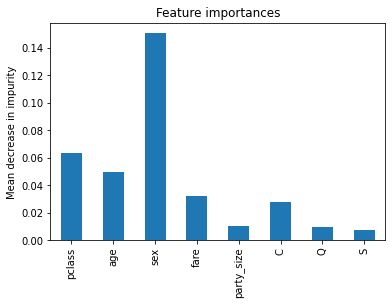

In [223]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

result = permutation_importance(
    best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar()
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")